<a href="https://colab.research.google.com/github/madrid42-ia/taller02-overfitting/blob/main/taller02-overfitting.ipynb" target=\\_parent\\><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

# Taller 2 - Entrenando a una red neuronal

## Objetivos de este taller
- Entender como entrenamos a una red neuronal.
- Saber lo que es el overfitting y el underfitting, y como combatirlos.
- Entender el concepto de batches
- Introducir un nuevo de tipo de capa, la convolucional.

Para entrenar a una red neuronal es importante tener siempre en mente la imagen de la montañita que vimos en el taller 1. El proceso que llamamos entrenamiento no deja de ser la serie de pasitos que vamos dando para optimizar nuestro modelo (es decir, para reducir la loss function).

## Overfitting y underfitting

En machine learning conocemos como overfitting al hecho de entrenar más de lo necesario a una red neuronal en un conjunto de datos demasiado pequeño. Basicamente ocurre cuando nuestro modelo se aprende de memoria nuestro dataset de entrenamiento, reduciendo mucho la loss en este pero siendo incapaz de generalizar al resto de datos posibles.

Recordemos que el dataset no corresponde con todos los posibles inputs a nuestro modelo. Por ejemplo, 60000 fotos de digitos escritos a mano pueden ser suficientes para entrenar a una red neuronal pero no se acerca a las miles de millones de formas un poco distintas de escribir un dos. Nuestro objetivo no es que nuestra red distinga perfectamente que digito es cual dentro de esos 60000, si no que lo haga entre cualquier posible digito (que pueden ser millones, pero todos se parecen entre si).

El underfitting es todo lo contrario, ocurre cuando no entrenamos lo suficiente a nuestra red y ni siquiera es capaz de llegar a un limite adecuado en neustro set de entrenamiento.

<figure>
    <img src="assets/overfitting.png" style="width:100%"/>
    <figcaption style="font-size: 10px; margin-left: 20px">Source: geek for geeks</figcaption>
</figure>

Para evitar que nos pase esto vamos a dividir nuestro dataset en dos partes, el train set (>80%) y el test o validation set (10-20%). Durante el entranimiento normal iremos extrayendo datos del train set y cada x tiempo comprobaremos como de bien funciona nuestro modelo en el test set. De esta forma sabremos como de bien funciona nuestra red neuronal cuando trabaje sobre datos que nunca antes ha visto.

## Creando nuestro modelo

A continuación vamos a importar nuestrar librerias y empezar con nuestor ejemplo practico del taller. El objetivo será entrenar a un clasificador similar al del primer taller pero con fotos algo más complejas. Usaremos en dataset cifar-10 que contiene varias imagenes de 32x32 pixeles de 10 categorías distintas (perros, aviones, gatos...).

In [1]:
%matplotlib inline

from math import floor, ceil

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
torch.manual_seed(42)

dev = 'cuda' if torch.cuda.is_available() else 'cpu'

El dataset Cifar-10 viene listo para descargar en pytorch asi que vamos a sacarlo de ahí. A continuación vamos a dividirlo en train y test set y a definir nuestro array de clases. Es importante numerar las posibles categorías en una lista ya que nuestro modelo y dataset solo entiende de numeros, cada categoría corresponde con su indice en ese array, y así podremos comprobar como funciona nuestro modelo más adelante.

Otro concepto muy importante en el machine learning son las **batches**. Para aumentar la estabilidad del entrenamiento, acelerar el proceso y apaliar el overfitting es muy tipico juntar varias entradas del dataset (en este caso imagenes) en grupos. Y cada vez que vayamos a dar un pasito en el descenso (un optim step) vamos a hacerlo en base a la loss de todos estos datos a la vez. Cada grupo de datos de denomina batch y tiene el mismo tamaño (**batch_size**).

En este caso usaremos los [dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders) de pytorch para dividir nuestro dataset en batches.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
)
batch_size = 32

# Download the dataset
dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_proportion = .8
# Use only a small part of dataset for faster results
train_set, val_set = torch.utils.data.random_split(
    dataset, [floor(train_proportion*len(dataset)),
    ceil(len(dataset)*(1 - train_proportion))])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


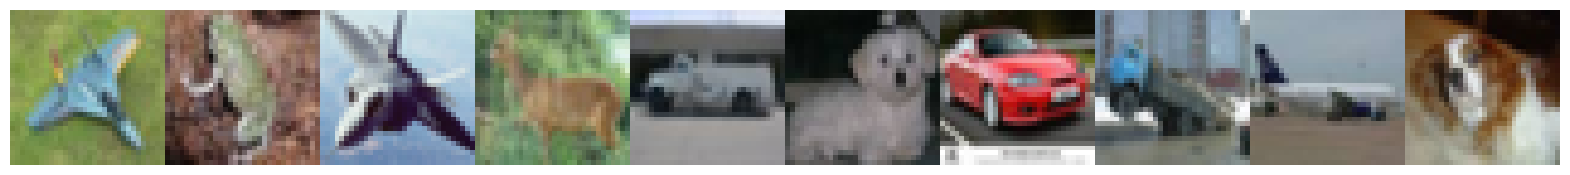

In [3]:
def concat_img(imgs):
    plt.figure(figsize=(20, 20))
    imgs = (imgs + 1) / 2
    imgs = imgs.movedim((0, 1, 2, 3), (0, 3, 1, 2)).detach().cpu().numpy() 
    axs = plt.imshow(np.concatenate(imgs.tolist(), axis=1))
    plt.axis('off')
    plt.show()
img, _ = next(iter(train_loader))
concat_img(img[:10])

En la siguiente celda definimos nuestro modelo. Es similar al de la sesión pasada pero añadiendo un nuevo tipo de capa que acepta imagenes en 2d, la convolucional. En proximos talleres profuncizaremos más en que quiere decir cada tipo de capa y como funciona cada una.

In [4]:
class BobNet(nn.Module):
    def __init__(self):
        super(BobNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(16, 16, 3),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(16, 16, 3),
            nn.LeakyReLU(inplace=True),
        )
        self.linear = nn.Sequential(
            nn.Linear(16*26*26, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Linear(512, len(classes)),
            nn.Softmax(dim=1),
        )
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        return self.linear(x)

Tras definir el modelo vamos a usar una función auxiliar para hacer nuestro loop de entrenamiento. En el vamos pasando cada batch del dataset por el modelo, calculando la loss y optimizando la red neuroal. Además de esto vamos guardando la loss y la accuracy del modelo para ver como fue el entrenamiento más tarde.

In [5]:
def train_loop(loader, model, loss_fn, optim, n_epochs=100):
    losses = []
    accs = []

    for epoch in trange(n_epochs):
        for x, y in (t := tqdm(loader, leave=False)):
            pred = model(x)
            loss = loss_fn(pred, y)

            for p in model.parameters():
                p.grad = None
            loss.backward()
            optim.step()

            loss = loss.item()
            losses.append(loss)

            y_hat = pred.argmax(dim=1)
            acc = len(torch.nonzero(y_hat == y)) / len(y)
            accs.append(acc)

            y_hat = pred.argmax(dim=1)
            acc = len(torch.nonzero(y_hat == y)) / len(y)
            accs.append(acc)

            t.set_description(f'loss={loss: .4f}, acc={acc: .4f}')
    return accs, losses

In [9]:
model = BobNet()
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

accs, losses = [1], [1]
#accs, losses = train_loop(train_loader, model, loss_fn, optim, n_epochs=20)

Vamos a mostrar como fue mejorando nuestro modelo tanto en terminos de loss como de accuracy

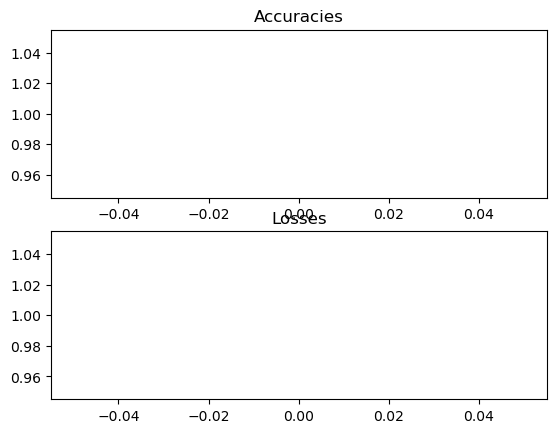

In [10]:
def plot(accs, losses):
    fig, axs = plt.subplots(2)
    axs[0].plot(accs, label='Accuracies')
    axs[0].set_title('Accuracies')
    axs[1].plot(losses, 'g', label='Losses')
    axs[1].set_title('Losses')
    
plot(accs, losses)

Por último vamos a ver como de bien funciona nuestro modelo en el test set, es decir, en datos que nunca antes había visto. Para esto vamos a crear otro dataloader de batch_size 1024 (simplemente para usar una unica batch para comprobarlo), y a calcular la accuracy.

In [15]:
def test_with_val_split():
    test_loader = torch.utils.data.DataLoader(val_set, batch_size=1024,
                                              shuffle=True, num_workers=2)

    x, y = next(iter(test_loader))
    model.eval()
    pred = model(x)
    y_hat = pred.argmax(dim=1)
    acc = len(torch.nonzero(y_hat == y)) / len(y)
    print(f'Final train accuracy of {accs[-1]:.4f}')
    print(f'The test accuracy is {acc: .4f}')

Como podemos ver el modelo es sustancialmente peor en el test set. Esto es normal e inevitable, pero nuestro objetivo es conseguir la mejor métrica posible en el test set.

Para esto vamos a modificar un poco nuestra red, reduciendo su tamaño y añadiendo alguna capa extra.

In [ ]:
class BobNet2(nn.Module):
    def __init__(self):
        super(BobNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(16, 16, 3),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(16, 16, 3),
            nn.LeakyReLU(inplace=True),
        )
        self.linear = nn.Sequential(
            nn.Linear(16*26*26, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Linear(512, len(classes)),
            nn.Softmax(dim=1),
        )
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        return self.linear(x)
    
model = BobNet()
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=5e-4)

accs, losses = train_loop(train_loader, model, loss_fn, optim, n_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

In [ ]:
test_with_val_split()

## Recursos importantes

Para terminar el taller vamos añadir enlaces a la documentación así como tutoriales de las librerías más importantes que usamos tanto en este como en futuros talleres. 

- Pytorch:
    - [docs](https://pytorch.org/tutorials/index.html)
    - [tutorial](https://youtu.be/IC0_FRiX-sw)


- Numpy:
    - [docs](https://numpy.org/doc/stable/)
    - [tutorial](https://youtu.be/xECXZ3tyONo)
    
    
- Matplotlib:
    - [docs](https://matplotlib.org/stable/tutorials/introductory/pyplot.html)
    - [tutorial](https://youtu.be/nzKy9GY12yo)


- Tqdm:
    - [docs](https://tqdm.github.io)
    - [tutorial](https://youtu.be/XmoOV38DamA)